In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm 
from sklearn import decomposition
import time

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 07: Redução de dimensionalidade

**1.** Considere o conjunto de dados disponível em penguins.csv, organizado em 5
colunas, sendo 4 colunas de atributos e a última a classe do padrão. Os dados
referem-se a medições anatômicas de pinguins da Antártida, classificados nas
espécies Adelie, Chinstrap e Gentoo. Maiores detalhes sobre os dados podem
ser conferidos em https://allisonhorst.github.io/palmerpenguins/.

**a)** Apresente a projeção em 2 dimensões dos padrões acima obtida pelo método PCA (análise dos componentes principais).

**b)** Ainda considerando o item anterior, calcule e mostre a variância explicada obtida quando a dimensão projetada é modificada (1,2,3 ou 4).

Normalize os dados antes de executar PCA. Implemente sua própria versão de PCA, mas verifique a corretude comparando contra alguma implementação popular (e.g., da biblioteca scikitlearn).

In [17]:
# Importando o dataset:
data = torch.from_numpy(pd.read_csv("./penguins.csv", header=None).to_numpy())

In [32]:
def PCA(X, n_components):
    """
    Implementação do PCA
    :param X: Input data
    :param n_components: Número de componentes principais 
    :return: Projeção dos dados, autovalores e autovetores
    """
    
    # Normalização dos dados
    X = (X - X.mean(dim=0)) / X.std(dim=0)
    
    # Cálculo da matriz de covariância
    C = torch.mm(X.T, X) / (X.shape[0] - 1)
    
    # Decomposição espectral
    eigvals, eigvecs = torch.linalg.eigh(C)
    
    # Ordenando os autovalores e autovetores
    idx = eigvals.argsort(descending=True)
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    
    # Projeção dos dados
    X_proj = torch.mm(X, eigvecs[:, :n_components])
    
    return X_proj, eigvals, eigvecs

In [34]:
X_proj, eigvals_proj, eigvecs_proj = PCA(data[:, :-1], 2)

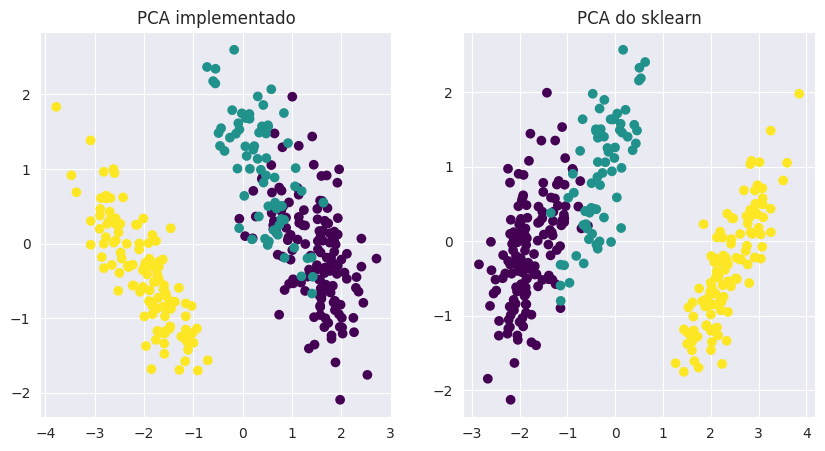

In [35]:
sklearn_pca = decomposition.PCA(n_components=2)
X = (data - data.mean(dim=0)) / data.std(dim=0)
X_proj_sklearn = sklearn_pca.fit_transform(X.numpy())

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(X_proj[:, 0], X_proj[:, 1], c=data[:, -1], cmap='viridis')

ax[1].scatter(X_proj_sklearn[:, 0], X_proj_sklearn[:, 1], c=data[:, -1], cmap='viridis')

ax[0].set_title("PCA implementado")
ax[1].set_title("PCA do sklearn")
plt.show()

Como podemos ver, a projeção dos dados obtida pela implementação do PCA é idêntica à obtida pela implementação do sklearn, a não ser por uma inversão de sinal no eixo y. Isso ocorre porque a direção dos autovetores não é única, e a implementação do sklearn pode escolher a direção oposta à nossa.

In [37]:
# Show the explained variance for different number of components
explained_variance = [torch.sum(eigvals_proj[:i]) / torch.sum(eigvals_proj) for i in range(1, 5)]
explained_variance

[tensor(0.6863, dtype=torch.float64),
 tensor(0.8809, dtype=torch.float64),
 tensor(0.9730, dtype=torch.float64),
 tensor(1., dtype=torch.float64)]

**2.** Implemente um autoencoder determinísitco para o banco de dados MNIST, que já usamos em exercícios anteriores. Você pode escolher utilizar tanto CNN como MLP no encoder/decoder. No entanto, o encoder deve mapear as imagens no $\mathbb{R}^2$, para podermos visualizar as representações latentes no plano. Use o conjunto de validação para fazer early stopping. Você também pode monitorar o erro na validação para anelar a taxa de aprendizado (usando um scheduler). Finalmente, mostre a projeção das imagens de teste no espaço latente e comente qualitativamente os embeddings obtidos.

In [21]:
train_val_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

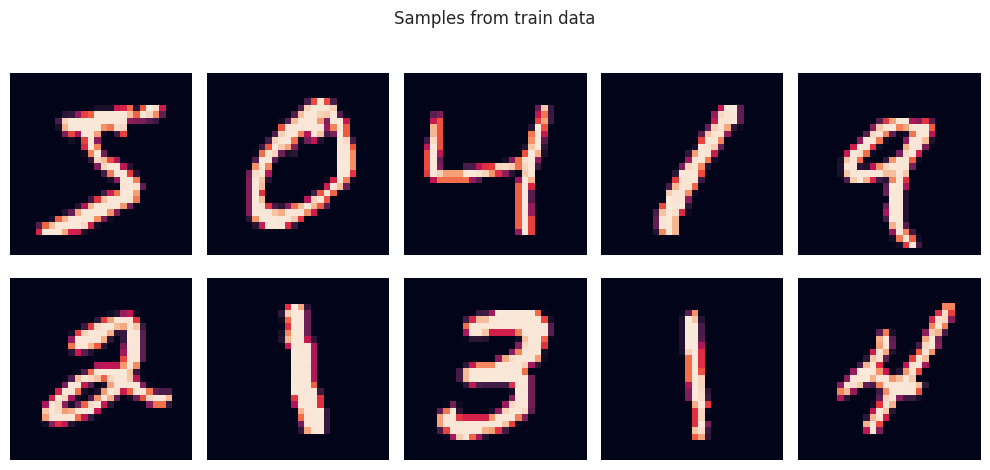

In [22]:
fig, ax = plt.subplots(2,5, figsize=(10,5))

for i in range(10):
    ax[i//5,i%5].imshow(train_val_dataset.data[i])
    ax[i//5,i%5].axis('off')
    
fig.suptitle("Samples from train data")
fig.tight_layout()